In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell'

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, rand

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from graphframes import *

In [4]:
from IPython.display import SVG
import numpy as np
import networkx as nx

from sknetwork.data import from_edge_list
from sknetwork.clustering import Louvain, get_modularity
from sknetwork.linalg import normalize
from sknetwork.utils import get_membership
from sknetwork.visualization import svg_graph

from sknetwork.embedding import ForceAtlas
from sknetwork.embedding import Spring

In [5]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('InnostageTask04') \
    .config('spark.driver.memory', '2g') \
    .getOrCreate()

23/02/05 18:26:27 WARN Utils: Your hostname, Alex.local resolves to a loopback address: 127.0.0.1; using 192.168.0.197 instead (on interface en0)
23/02/05 18:26:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/usr/local/Cellar/apache-spark/3.3.0/libexec/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/aleksandrmorozov/.ivy2/cache
The jars for the packages stored in: /Users/aleksandrmorozov/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c13ac331-5209-4135-9eda-2fe9b0aad992;1.0
	confs: [default]
	found graphframes#graphframes;0.8.1-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 121ms :: artifacts dl 4ms
	:: modules in use:
	graphframes#graphframes;0.8.1-spark3.0-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-----------

23/02/05 18:26:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Подготовка данных

In [6]:
df = spark.read \
    .option('sep', ';') \
    .option('header', True) \
    .csv('data.csv')

df = df.where('not (src is null) and not (dst is null)') \
    .where("not (src = '0.0.0.0') and  not (dst = '0.0.0.0')") \
    .where("not (src = '127.0.0.1') and  not (dst = '127.0.0.1')") \
    .where("not (src = dst)") \
    .filter(df.src.rlike("^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$")) \
    .filter(df.dst.rlike("^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$"))

df.show(10)

+------------+---------------+---+
|         src|            dst|cnt|
+------------+---------------+---+
|     0.0.0.1| 125.194.32.168|  4|
|    0.0.0.60| 125.194.32.168|  4|
|0.199.82.141|255.255.255.255|  9|
|  0.77.160.4| 125.194.32.185|  1|
|  0.77.181.3| 125.194.32.167|  1|
|     1.0.0.0| 125.194.32.188| 15|
|     1.0.0.0| 125.194.32.190|  7|
|     1.0.0.0|255.255.255.255|  2|
| 1.0.128.150| 125.194.32.161|  2|
| 1.0.128.158| 125.194.32.186|  1|
+------------+---------------+---+
only showing top 10 rows



## Построение и анализ графа

Так как наш граф состоит из более чем 1.5 млн. вершин, для его анализа сначала необходимо выделить сообщества.

Для выделения сообществ существует множество различных алгоритмов: LPA, подсчет треугольников, сильно связанные компоненты и Лувенский модульный алгоритм. 

Лувенский модульный алгоритм является одним из самых быстрых алгоритмов выделения сообществ, а также оптимально подходит для анализа крупномасштабных сетей.

In [7]:
edges = [(i[0], i[1]) for i in df.rdd.map(tuple).collect()]
edges[:5]

[('0.0.0.1', '125.194.32.168'),
 ('0.0.0.60', '125.194.32.168'),
 ('0.199.82.141', '255.255.255.255'),
 ('0.77.160.4', '125.194.32.185'),
 ('0.77.181.3', '125.194.32.167')]

In [8]:
'''Построение графа и выеделение сообществ с помощью Лувенского алгоритма'''

graph = from_edge_list(edges, directed=True)
louvain = Louvain()
labels = louvain.fit_transform(graph.adjacency)
labels_unique, cnt = np.unique(labels, return_counts=True)

In [9]:
'''Маркировка ip-адресов в соответствии с сообществом, к которому они относятся'''

groups = []
for label, size in zip(labels_unique, cnt):
    group = f'Group_{label}: {size}'
    groups.append(group)

In [10]:
agg_graph = louvain.aggregate_  # аггрегируем граф по сообществам

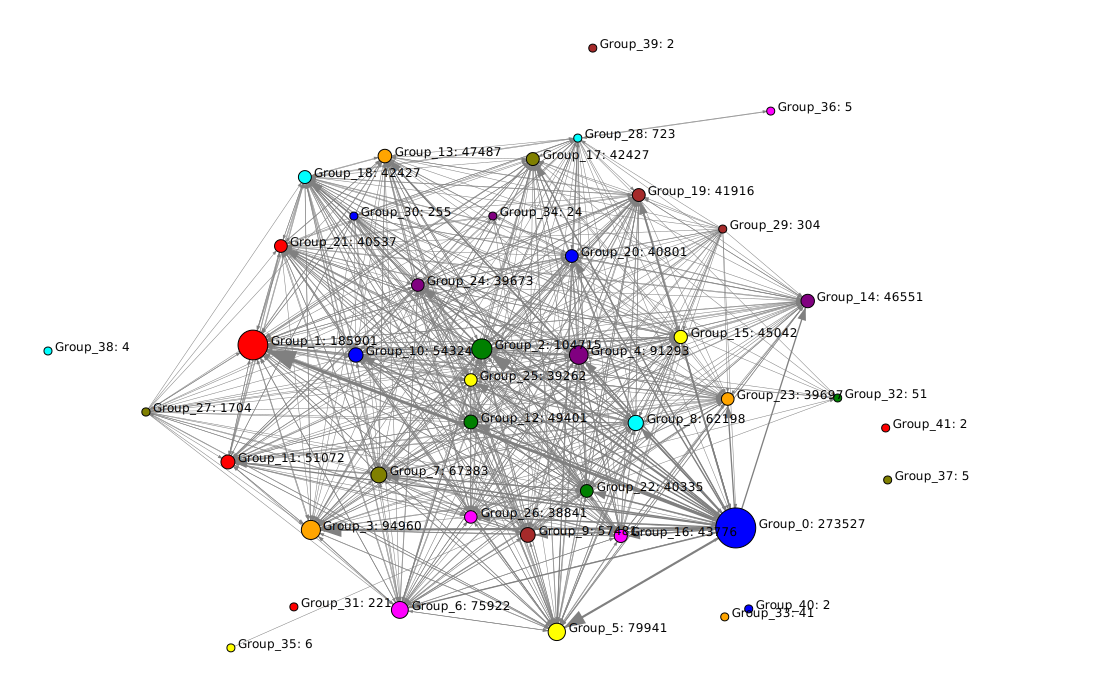

In [35]:
'''Отрисовка графа'''

layout = ForceAtlas(gravity_factor=0.1,
                    tolerance=1.5,
                    approx_radius=20)
pos = layout.fit_transform(agg_graph)

image = svg_graph(agg_graph, labels=labels_unique,
                  width=700, height=500,
                  names=groups,
                  position=pos,
                  edge_width_max=3,
                  node_size_min=4,
                  node_size_max=20,
                  scale=1.2,
                  margin=40,
                  display_node_weight=True, node_weights=cnt)

SVG(image)

Выделение сообществ позволяет не только многократно сократить количество переборов, но и дает возможность получить более полное представление о структуре сети и выявить потенциальные цели для атаки.  Так, крупные узлы в сети будут находится под наибольшей угрозой. Потому в нашем графе мы будем пытаться выявить самые длинные пути до этих узлов. 

# Поиск вектора атаки

Путем простого перебора выявим самые длинные пути до крупных сообществ с помощью networkx.

In [12]:
G = nx.from_scipy_sparse_array(agg_graph, create_using=nx.DiGraph)

In [13]:
res = []
dest = [0, 1, 2, 3, 4, 5]
source = [i for i in labels_unique if i not in dest]
timeout = 1000

for s in source:
    for d in dest:
        paths = nx.all_simple_paths(G, source=s, target=d)
        for i, p in enumerate(paths):
            p = [str(i) for i in p]
            row = (str(s), str(d), p, len(p))
            res.append(row)
            if i == timeout:
                break
                
del G

In [14]:
'''Запишем результаты в таблицу и отсортируем их в порядке убывания длины пути'''

res_rdd = spark.sparkContext.parallelize(res, numSlices=300)

res_schema = StructType([
    StructField('src', StringType(), True),
    StructField('dst', StringType(), True),
    StructField('path', ArrayType(StringType()), True),
    StructField('len', IntegerType(), True)
])

res_df = spark.createDataFrame(data=res_rdd, schema=res_schema)
del res

In [15]:
res_df.sort(res_df.len.desc()).show(5)

+---+---+--------------------+---+
|src|dst|                path|len|
+---+---+--------------------+---+
| 17|  3|[17, 0, 1, 2, 4, ...| 31|
| 17|  1|[17, 0, 2, 3, 5, ...| 31|
| 17|  1|[17, 0, 2, 3, 5, ...| 31|
| 17|  1|[17, 0, 2, 3, 5, ...| 31|
| 17|  1|[17, 0, 2, 3, 5, ...| 31|
+---+---+--------------------+---+
only showing top 5 rows



Самые длинные пути в нашем графе проходят через 31 сообщество. Отфильтруем повторяющиеся пары src, dst

In [16]:
res_df = res_df.filter('len = 31').dropDuplicates(['src', 'dst'])
res_df.show(5)

+---+---+--------------------+---+
|src|dst|                path|len|
+---+---+--------------------+---+
| 17|  1|[17, 0, 2, 3, 5, ...| 31|
| 17|  3|[17, 0, 1, 2, 4, ...| 31|
| 17|  5|[17, 0, 1, 2, 3, ...| 31|
| 21|  0|[21, 1, 2, 3, 5, ...| 31|
| 23|  0|[23, 1, 2, 3, 5, ...| 31|
+---+---+--------------------+---+
only showing top 5 rows



Таким образом мы получили таблицу с потенциальными векторами атак.

# Обнаружение ip-адресов, проходящих по выявленным путям

Сначала найдем мосты – ip-адреса, которые осуществляют связь между сообществами.

Например, имея путь 17->0->2->… найдем такие пары src ip и dst ip, где src находится в группе 17, а dst в 0. Затем будем искать пару из 0 в 2 и так далее. Это можно осуществить с помощью поиска в ширину. 

Для этого можно воспользоваться пакетом graphframes, так как он позволяет осуществлять поиск исходя из характеристик вершин.

In [17]:
'''Построим наш граф. Так же добавим столбец с номерами сообществ, к которым относятся наши ip-адреса'''

graph_schema = StructType([
    StructField('id', StringType(), True),
    StructField('label', StringType(), True)
])

id_list = graph.names
node_data = [(str(id_list[i]), str(labels[i])) for i in range(len(id_list))]
rdd = spark.sparkContext.parallelize(node_data, numSlices=60)

nodes = spark.createDataFrame(data=rdd, schema=graph_schema)
gfr = GraphFrame(nodes, df)
gfr.vertices.show(5)

+-------------+-----+
|           id|label|
+-------------+-----+
|      0.0.0.1|   20|
|     0.0.0.60|   20|
|    0.0.5.195|   22|
|0.129.255.255|   33|
|  0.15.102.90|   22|
+-------------+-----+
only showing top 5 rows



/usr/local/Cellar/apache-spark/3.3.0/libexec/python/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [18]:
'''Напишем функцию для нахождения мостов'''

def collect_edges(df, edges):
    
    length = len(df.columns)
    i = 2
    j = 0
    while i < length:
        edge = df.select(f'e{j}').collect()[0][0]
        edges.append((edge[0], edge[1]))
        j += 1
        i += 2
    
    return edges


def find_bridges(path, gfr):
    bridges = []
    
    for i in range(len(path)-1):
        res = gfr.bfs(f"label = {path[i]}", f'label = {path[i+1]}')
        bridges = collect_edges(res, bridges)
        
    return bridges

In [19]:
'''Обнаружив мосты, необходимо соединить их, то есть найти путь от dst_ip[n] до src_ip[n+1]'''

def find_path(path, bridges, gfr, maxPath=5):
    
    n_path = path[1:]
    edges = []

    for i in range(len(bridges)-1):
        edges.append(bridges[i])
        
        if bridges[i][1] != bridges[i+1][0]:
            res = gfr.filterVertices(f'label = {n_path[i]}') \
                    .bfs(f"id = '{bridges[i][1]}'", f"id = '{bridges[i+1][0]}'",
                        maxPathLength=maxPath)
            
            edges = collect_edges(res, edges)

    edges.append(bridges[-1])
    return edges

In [20]:
res_df.show(5)

+---+---+--------------------+---+
|src|dst|                path|len|
+---+---+--------------------+---+
| 17|  1|[17, 0, 2, 3, 5, ...| 31|
| 17|  3|[17, 0, 1, 2, 4, ...| 31|
| 17|  5|[17, 0, 1, 2, 3, ...| 31|
| 21|  0|[21, 1, 2, 3, 5, ...| 31|
| 23|  0|[23, 1, 2, 3, 5, ...| 31|
+---+---+--------------------+---+
only showing top 5 rows



In [23]:
path = res_df.collect()[0][2]
bridges = find_bridges(path, gfr)
bridges[:10]

/usr/local/Cellar/apache-spark/3.3.0/libexec/python/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


[('192.168.5.100', '125.194.32.183'),
 ('1.175.161.241', '125.194.32.167'),
 ('112.134.57.145', '125.194.32.178'),
 ('10.79.12.105', '125.194.32.189'),
 ('103.130.70.19', '125.194.32.186'),
 ('101.191.17.181', '125.194.32.173'),
 ('103.106.193.2', '125.194.32.181'),
 ('1.212.69.28', '125.194.32.162'),
 ('107.175.136.192', '125.194.32.191'),
 ('103.69.219.99', '125.194.32.160')]

In [25]:
attack_vector = find_path(path, bridges, gfr, 1)
attack_vector[:10]

[('192.168.5.100', '125.194.32.183'),
 ('1.175.161.241', '125.194.32.167'),
 ('112.134.57.145', '125.194.32.178'),
 ('10.79.12.105', '125.194.32.189'),
 ('103.130.70.19', '125.194.32.186'),
 ('101.191.17.181', '125.194.32.173'),
 ('103.106.193.2', '125.194.32.181'),
 ('1.212.69.28', '125.194.32.162'),
 ('107.175.136.192', '125.194.32.191'),
 ('103.69.219.99', '125.194.32.160')]

Так как наши сообщества достаточно крупные, нахождение путей до мостов является очень ресурсозатратной задачей. Чем больше глубина поиска, тем больше времени и памяти необходимо затратить. Потому найти точный путь не всегда предоставляется возможным.
Нам известно, что dst_ip[n] и src_ip[n+1] лежат в одной группе (из пути 17->0->2 мы получим пары (17, 0) и (0, 2)), а значит недостающие вершины можно заменить группами, внутри которых находится путь.

In [27]:
final_vector = []
p = path

j = 0
for i in range(len(attack_vector)-1):
    final_vector.append(attack_vector[i])
    if attack_vector[i][1] != attack_vector[i+1][0]:
        g = gfr.vertices.where(f"id = '{attack_vector[i][1]}'").select('label').collect()[0][0]
        final_vector.append((attack_vector[i][1], g))
        final_vector.append((g, attack_vector[i+1][0]))
    else:
        continue
    j+=1

final_vector.append(attack_vector[-1])
final_vector[:10]

[('192.168.5.100', '125.194.32.183'),
 ('125.194.32.183', '0'),
 ('0', '1.175.161.241'),
 ('1.175.161.241', '125.194.32.167'),
 ('125.194.32.167', '2'),
 ('2', '112.134.57.145'),
 ('112.134.57.145', '125.194.32.178'),
 ('125.194.32.178', '3'),
 ('3', '10.79.12.105'),
 ('10.79.12.105', '125.194.32.189')]

Проверим, существует ли такой путь в графе. В цикле пробегаемся по вектору атаки и ищем соответствующие пары src, dst в графе. Если путь не найден возвращаем пустой лист, в случае успеха возвращаем найденный путь.

In [28]:
def check_vector(gfr, final_vector, group_list):
    
    res = []
    for v1, v2 in final_vector:
        
        if v1 in group_list:
            path = gfr.bfs(f'label = {v1}', f"id = '{v2}'", maxPathLength=1)
        elif v2 in group_list:
            path = gfr.bfs(f"id = '{v1}'", f'label = {v2}', maxPathLength=1)
        else:
            path = gfr.bfs(f"id = '{v1}'", f"id = '{v2}'", maxPathLength=1)

        if path.isEmpty():
            print(f'Path {v1}->{v2} not found')
            return []
        else:
            res.append((v1, v2))
    
    return res

In [29]:
group_list = [str(i) for i in labels_unique]
result = check_vector(gfr, final_vector, group_list)

Проверка прошла успешно, полученный вектор атаки был найден в графе.

## Финальный резльтат

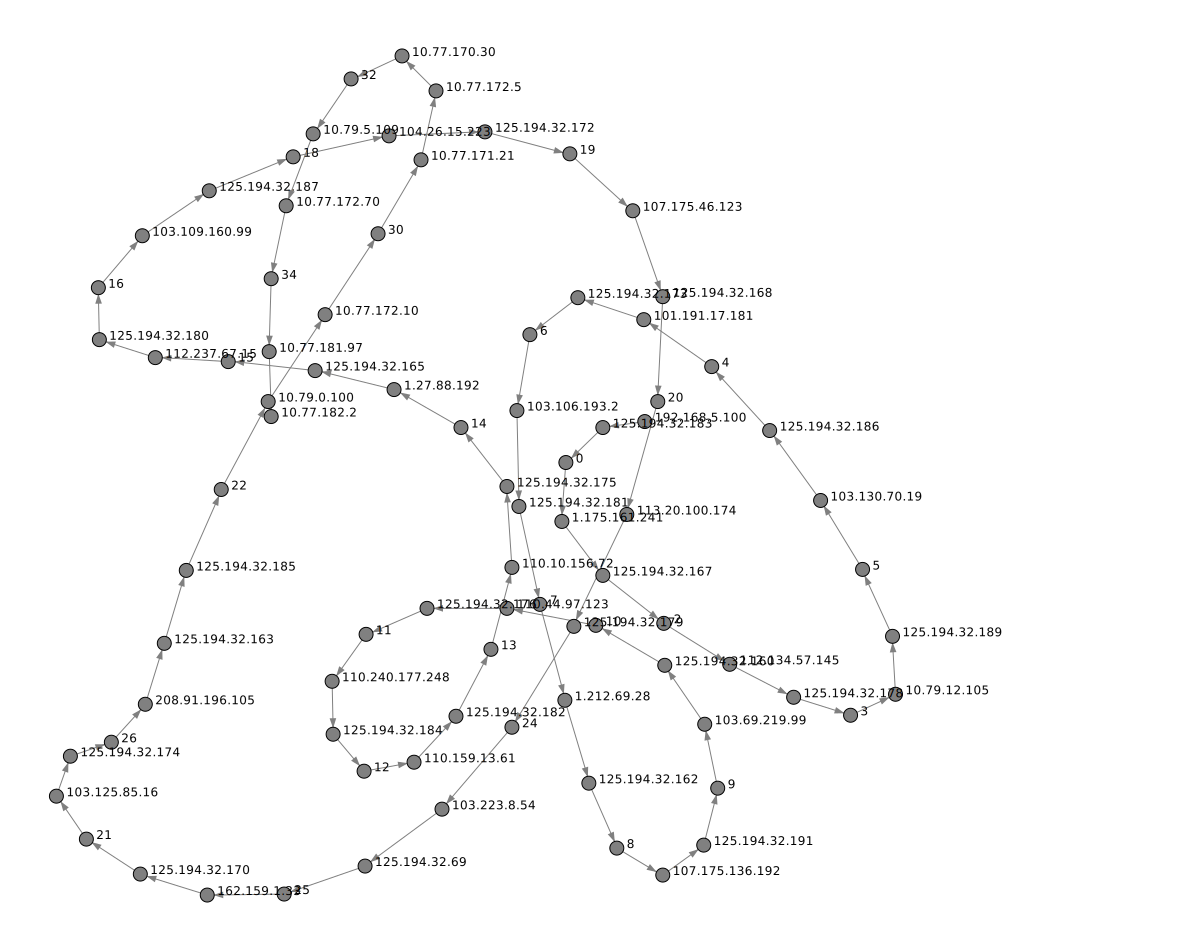

In [31]:
vect_g = from_edge_list(final_vector, directed=True)
image = svg_graph(vect_g.adjacency, 
                  names=vect_g.names,
                  width=600, height=600,
                  node_size_min=4,
                  node_size_max=20,
                  scale=1.4,
                  margin=40)

SVG(image)